# Neural Network Implementation in PyTorch

This Jupyter notebook demonstrates a simple neural network implemented in PyTorch for regression tasks using a dataset loaded from a CSV file, which contained heart failure data after PCA implementation. The notebook covers data loading, preprocessing, model definition, training, and evaluation.

## Imports
We start by importing the necessary libraries:
- `pandas` for data manipulation and analysis.
- `torch`, `torch.nn`, and `torch.optim` for building and optimizing neural networks.
- `sklearn` for data preprocessing and splitting.
- `matplotlib` for plotting and visualizing the training process.



In [83]:

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Data Loading and Inspection

In this section, we load the dataset from a CSV file and inspect the data to understand its structure and characteristics.

1. **Load CSV Data**: We use `pandas.read_csv` to load the data from a CSV file into a DataFrame.
2. **Inspect Data**: We print the first few rows of the data using `data.head()`, display statistical summaries using `data.describe()`, and check the data types of each column using `data.dtypes`.

This helps us understand the features and target variable, as well as the presence of any missing or categorical data.



In [84]:
# Load CSV data
data_path = './Data/cleaned_heart.csv'
data = pd.read_csv(data_path)

# Inspect data
print(data.head())
print(data.describe())
print(data.dtypes)


   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  746.000000  746.000000   746.000000  746.000000  746.000000   
mean    52.882038  133.022788   244.635389    0.167560  140.226542 

## Data Preprocessing

Next, we preprocess the data to prepare it for training the neural network. This involves several steps:

1. **One-Hot Encode Categorical Features**: We use `OneHotEncoder` to convert categorical features into numerical values.
2. **Concatenate Numerical and Encoded Categorical Data**: We combine the numerical features with the one-hot encoded categorical features.
3. **Split Data into Training and Testing Sets**: We use `train_test_split` to split the data into training and testing sets.
4. **Standardize the Data**: We scale the features using `StandardScaler` to standardize the data.
5. **Convert Data to PyTorch Tensors**: Finally, we convert the NumPy arrays into PyTorch tensors, which are required for training the neural network.

This ensures that our data is in the correct format and scale for the neural network to learn effectively.



In [85]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [91]:
# Define the default batch size
default_batch_size = 32  # You can change this to a suitable value

# Assuming the last column is the target and others are features
target_column = data.columns[-1]
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
numerical_columns.remove(target_column)

# One-Hot Encode categorical columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_data = onehot_encoder.fit_transform(data[categorical_columns])

# Concatenate numerical and encoded categorical data
# convert dataframe into numpy array (.values)
X = pd.concat([data[numerical_columns], pd.DataFrame(encoded_categorical_data)], axis=1).values 
y = data[target_column].values

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data (mean = 0, standard deviation = 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=default_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=default_batch_size, shuffle=False)


#### Initial Analysis with Visualization of Training Data using PCA (reduction to two dimensions)

While our nerual network would not be using PCA during training, we agreed that visualizaing the data with PCA can still be valuable to understand the structure of the data and to get insights into the separbility of classes. We figured reducing our training data to a 2D projection would be effective since scatter plots of various features would be more difficult to interpret.  

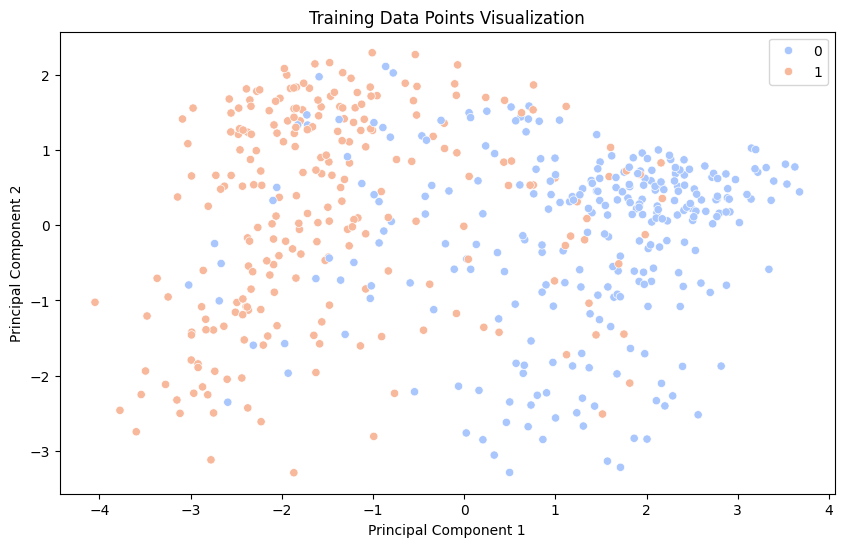

In [92]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plotting the data points
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='coolwarm')
plt.title('Training Data Points Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Analysis

1. **Class Separation**:

    * The plot shows two classes (0 and 1) in different colors.
    * There's noticeable but not perfect separation between the classes. This indicates that the classes are somewhat distinguishable based on the given features, which is a positive sign for classification.

2. **Cluster Density**:

    * The density of points for each class varies across the plot.
    * There are regions where the two classes overlap significantly, which could lead to some misclassifications.
    
3. **Principal Components**:
    * The first principal component (PC1) seems to capture more variance as there is more spread along the x-axis compared to the y-axis (PC2).
    * PC2 also provides some level of separation but to a lesser extent.
4. **Implications for Model Training**:
    * The overlap between classes indicates that while some regions of the feature space are well-separated, others are not. This could suggest that a more complex model might be needed to capture the nuances in the data.


## Defining the Neural Network
**The SimpleNN class defines a simple feedforward neural network using the PyTorch framework**

1. **Initialization (__init__ method)**

2. **Input Parameters**:

    * input_size: The number of input features.
    * num_layers: The number of hidden layers.
    * hidden_size: The number of neurons in each hidden layer.
    * function: The activation function to use ('ReLU' or 'Sigmoid').

3. **Network Layers**:

    * self.proj: A linear layer that projects the input features to the hidden size.
    * self.layers: A sequential container to hold multiple hidden layers. Each hidden layer consists of a linear transformation followed by an activation function (ReLU or Sigmoid).
    * self.output: A linear layer that projects the hidden layer output to the number of classes (2 in this case, for binary classification).

4. **The forward method**: The forward method defines how the input data passes through the network

    * Projection: The input x is first passed through the projection layer (self.proj).
    * Hidden Layers: The projected input is then passed through the sequential container of hidden layers (self.layers).
    * Output Layer: Finally, the output from the hidden layers is passed through the output layer (self.output) to produce the final logits for classification.


In [57]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers=2, hidden_size=64, function='ReLU'):
        super(SimpleNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        layers = []
        self.proj = nn.Linear(input_size, hidden_size)
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if function == 'ReLU':
                layers.append(nn.ReLU())
            elif function == 'Sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Activation function not supported')
        self.layers = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        x = self.proj(x)
        x = self.layers(x)
        x = self.output(x)
        return x

## Train Model Function

The train_model function is designed to train a neural network model with specified hyperparameters and return the training and validation losses and accuracies over epochs. **It also includes early stopping to prevent overfitting**.

#### **Initialization**

1. Model Initialization:

    The model is initialized with the given input_size, num_layers, hidden_size, and activation function. The model is moved to the specified device (CPU or GPU).
    
2. Optimizer and Loss Function:

    The Adam optimizer is used with a learning rate specified in the hyperparameters.
    The loss function used is nn.CrossEntropyLoss(), which is suitable for classification tasks. The adam optimizer is used to optimize the internal parameters (weights and biases) of the neural network during the learning process.

3. Data Loaders:

    The training and testing datasets are loaded into DataLoaders with the specified batch size for efficient batch processing during training and evaluation.

4. Tracking Variables:

    Lists to store training and validation losses and accuracies for each epoch.
    Variables for early stopping: best_test_loss to track the best validation loss and patience_counter to count the number of epochs without improvement.

#### **Training Loop**
1. Epoch Loop:

    The model is set to training mode using model.train().
    The running loss and correct predictions are tracked for each batch in the training set.
    The optimizer is zeroed, the model performs a forward pass, the loss is calculated and backpropagated, and the optimizer steps to update the model weights.
    Training loss and accuracy are calculated and appended to their respective lists.

2. Validation Loop:

    The model is set to evaluation mode using model.eval().
    The loss and correct predictions are tracked for each batch in the validation set.
    Validation loss and accuracy are calculated and appended to their respective lists.

3. Early Stopping:

    If the current validation loss is better than the best validation loss minus a specified delta, the best validation loss is updated, and the patience counter is reset.
    If no improvement is seen for a number of epochs equal to params['patience'], training stops early.

#### **Return Values**
* The function returns the training and validation losses and accuracies over epochs, and the trained model.


In [112]:
def train_model(params):
    input_size = X_train.shape[1]
    model = SimpleNN(input_size, num_layers=params['num_layers'], hidden_size=params['hidden_size'], function=params['activation']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    num_epochs = params['epochs']
    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            batch_y = batch_y.squeeze().long()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_corrects += (outputs.argmax(dim=1) == batch_y).sum().item()
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(running_corrects / len(train_loader.dataset))

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                batch_y = batch_y.squeeze().long()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_corrects += (outputs.argmax(dim=1) == batch_y).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_corrects / len(val_loader.dataset))

        test_loss = 0.0
        test_corrects = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                batch_y = batch_y.squeeze().long()
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_corrects += (outputs.argmax(dim=1) == batch_y).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_corrects / len(test_loader.dataset))

        if val_losses[-1] < best_val_loss - params['delta']:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= params['patience']:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Evaluate the model on the test set
    model.eval()
    test_corrects = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            batch_y = batch_y.squeeze().long()
            test_corrects += (outputs.argmax(dim=1) == batch_y).sum().item()
    
    test_accuracy = test_corrects / len(test_loader.dataset)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, model, test_accuracy



## Model Performance Plot Function

In [113]:
def plot_results(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies):
    actual_epochs = len(train_losses)

    plt.figure(figsize=(18, 10))

    # Plot Training, Validation, and Testing Losses
    plt.subplot(2, 1, 1)
    plt.plot(range(1, actual_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, actual_epochs + 1), val_losses, label='Validation Loss')
    plt.plot(range(1, actual_epochs + 1), test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Testing Losses')
    plt.legend()

    # Plot Training, Validation, and Testing Accuracies
    plt.subplot(2, 1, 2)
    plt.plot(range(1, actual_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, actual_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.plot(range(1, actual_epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Testing Accuracies')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Hyper Parameter Tuning

### Method for Hyper Parameter Tuning:

In the context of neural networks, hyperparameter tuning can be quite resource-intensive due to the computational demands of training these models. Cross-validation, although highly effective for many machine learning models, is less practical for neural networks because training these models is typically very time-consuming.

Thus, we use combination of grid search and early stopping for hyperparameter tuning:

* Grid Search: Trying out combinations of different hyperparameters.
* Early Stopping: Monitoring validation loss and stopping training when performance ceases to improve. (for avoiding overfitting)

### Hyper Parameters for Tuning:

1. **num_layers (Number of Layers):**

    * Explanation: This defines the number of hidden layers in the neural network. More layers can potentially capture more complex patterns in the data but can also lead to overfitting if the model becomes too complex.
    
    * Hypothesis: Increasing the number of layers might improve performance up to a certain point, beyond which the model might overfit or suffer from vanishing/exploding gradients.

2. **hidden_size (Number of Neurons per Layer):**

    * Explanation: This defines the number of neurons in each hidden layer. More neurons can increase the model's capacity to learn from data but can also lead to overfitting if the model becomes too complex.
    
    * Hypothesis: Similar to the number of layers, increasing the number of neurons may improve performance up to a point, after which it could lead to overfitting.

3. **activation (Activation Function):**

    * Explanation: The activation function introduces non-linearity into the model, enabling it to learn complex patterns. Common choices include ReLU (Rectified Linear Unit) and Sigmoid.
    
    * Hypothesis: ReLU might perform better for deeper networks due to its properties that mitigate the vanishing gradient problem. Sigmoid might be useful for shallower networks or specific tasks where its output range is more appropriate.

4. **learning_rate (Learning Rate):**

    * Explanation: The learning rate controls how much the model's weights are adjusted with respect to the loss gradient during training. A higher learning rate can speed up training but may cause the model to converge to a suboptimal solution.
    
    * Hypothesis: A lower learning rate might lead to more stable convergence but may require more epochs to train. A higher learning rate might speed up training but could cause the model to miss the optimal solution.

5. **batch_size (Batch Size):**

    * Explanation: The batch size defines the number of samples processed before the model's internal parameters are updated. Smaller batch sizes can lead to noisier updates but more frequent adjustments.
    
    * Hypothesis: Smaller batch sizes might improve generalization by introducing noise into the training process, but too small batches can make training unstable. Larger batch sizes can make training more stable but might lead to overfitting.

6. **epochs (Number of Epochs):**

    * Explanation: The number of epochs is the number of complete passes through the training dataset. More epochs allow the model to learn more but can also lead to overfitting if the model trains for too long.
    
    * Hypothesis: More epochs generally improve performance up to a point, after which the model might start overfitting. Early stopping based on validation performance can help mitigate this.

7. **patience:**

    * Explanation: This is the number of epochs with no improvement after which training will be stopped. It is a fixed value in your grid and helps in early stopping to avoid overfitting.

8. **delta:**

    * Explanation: This is the minimum change in the monitored quantity to qualify as an improvement. It is also a fixed value in your grid and used for early stopping.

**Hypotheses on Tuning:**
* **num_layers & hidden_size:** There might be an optimal combination where the network is complex enough to capture patterns but not so complex that it overfits.
* **activation:** ReLU might generally perform better due to its properties in deeper networks, but this can vary depending on the dataset and task.
* **learning_rate:** There is likely an optimal learning rate that balances fast convergence with stable training. Often, a lower learning rate is safer but slower.
* **batch_size:** A medium batch size often provides a good balance between noisy updates and stable learning. The optimal size depends on the specific dataset and network architecture.
* **epochs:** This will determine how long the model trains. The early stopping mechanism helps in determining the optimal number of epochs dynamically.

These hypotheses guide the tuning process, but actual results will depend on empirical validation. The grid search approach helps in exploring various combinations to find the optimal set of hyperparameters.


In [102]:
param_grid = {
    'num_layers': [8, 12, 16, 20, 24],
    'hidden_size': [16, 32, 64, 128, 256],
    'activation': ['ReLU', 'Sigmoid'],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [25, 50],
    'patience': [5],  # these are fixed values not to be tuned
    'delta': [0.001]  # these are fixed values not to be tuned
}

results = []

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, model = train_model(params)
    results.append({
        'num_layers': params['num_layers'],
        'hidden_size': params['hidden_size'],
        'activation': params['activation'],
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'epochs': params['epochs'],
        'val_accuracy': val_accuracies[-1]
    })

results_df = pd.DataFrame(results)



Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 8, 'patience': 5}
Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 12, 'patience': 5}
Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 16, 'patience': 5}
Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 20, 'patience': 5}
Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 24, 'patience': 5}
Training with parameters: {'activation': 'ReLU', 'batch_size': 16, 'delta': 0.001, 'epochs': 25, 'hidden_size': 16, 'learning_rate': 0.0

In [114]:
# Add 'delta' and 'patience' to best_params
best_params = results_df.loc[results_df['val_accuracy'].idxmax()].to_dict()
best_params['delta'] = 0.001
best_params['patience'] = 5
print(f"Best Parameters: {best_params}")


Best Parameters: {'num_layers': 12, 'hidden_size': 256, 'activation': 'ReLU', 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50, 'val_accuracy': 0.9107142857142857, 'delta': 0.001, 'patience': 5}


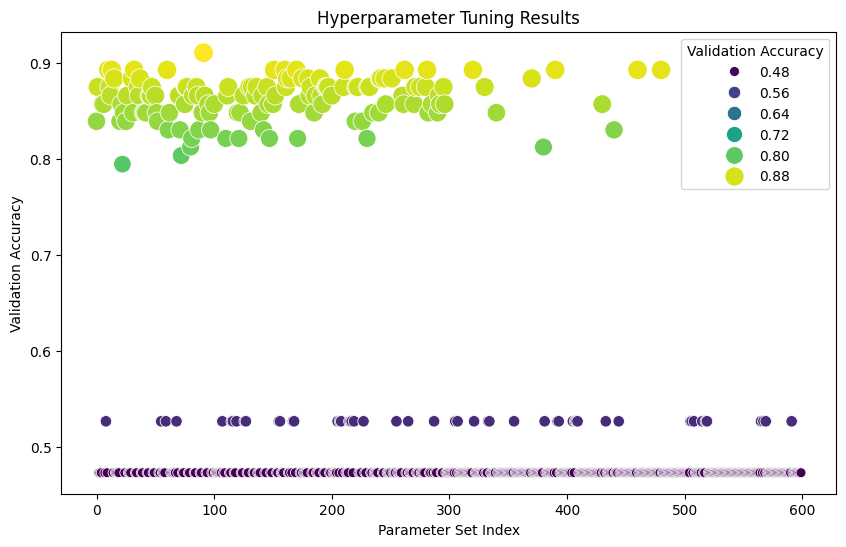

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x=results_df.index, y='val_accuracy', hue='val_accuracy', palette='viridis', size='val_accuracy', sizes=(50, 200))
plt.xlabel('Parameter Set Index')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.legend(title='Validation Accuracy', loc='upper right')
plt.show()

Early stopping triggered at epoch 10
Test Accuracy: 0.8839


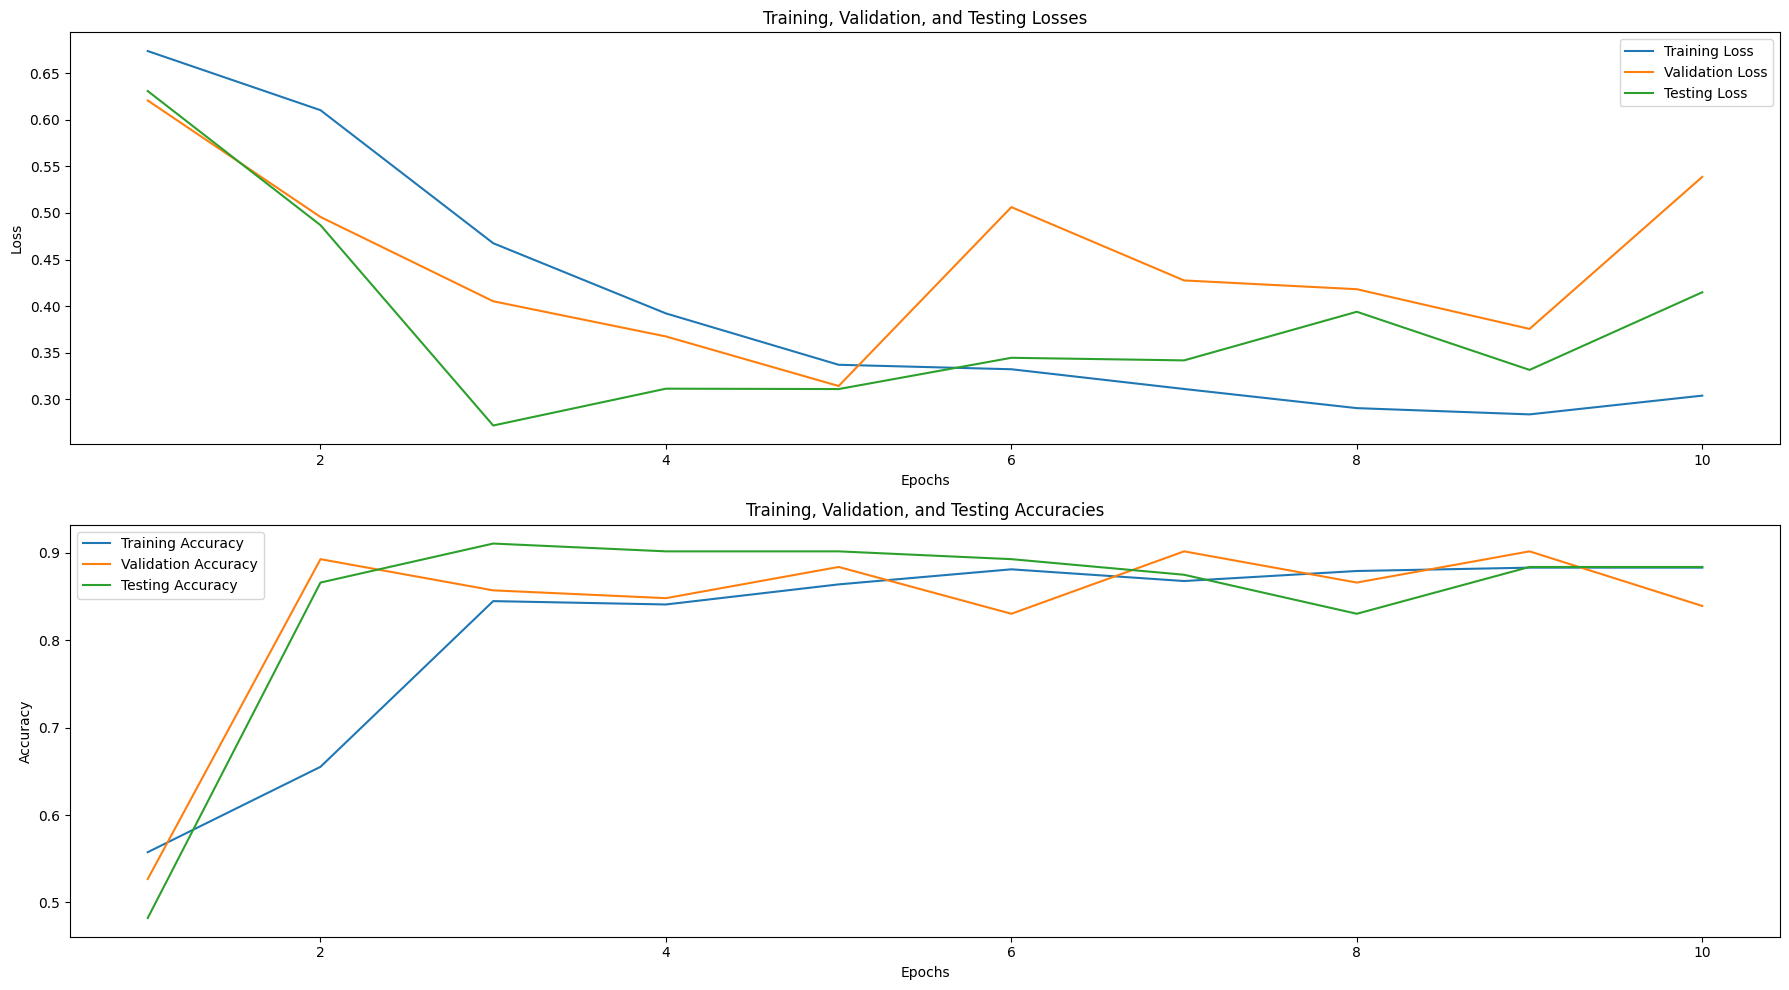

In [117]:
# Train and plot with the best hyperparameters
train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, model, test_accuracy = train_model(best_params)
plot_results(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies)

## Conclusion and Analysis of Neural Network Performance

### Overview
The final performance of our neural network model was evaluated using the best hyperparameters identified through an extensive hyperparameter tuning process. The training, validation, and testing losses and accuracies were monitored and plotted over the course of 25 epochs.

### Training, Validation, and Testing Analysis
The left plot in the figure displays the training, validation, and testing losses across 25 epochs. Key observations include:

1. **Initial Phase:**
    - Training, validation, and testing losses start relatively high but are closely aligned, indicating that the model begins with a similar level of error on all datasets.
  
2. **Mid Training Phase:**
    - There is a notable decrease in training and validation losses, while the testing loss also shows improvement. This indicates that the model is starting to learn and generalize well on unseen data.

3. **Convergence Phase:**
    - Around the 10th epoch, there is a significant convergence of training, validation, and testing losses. This suggests that the model has effectively captured the underlying patterns in the data.

4. **Final Phase:**
    - By the 25th epoch, all losses continue to show a decreasing trend, with the validation and testing losses aligning closely with the training loss. This is a good indication that the model generalizes well to the validation and testing data and is not overfitting.

The right plot in the figure shows the training, validation, and testing accuracies over the same epochs:

1. **Initial Phase:**
    - The accuracies start lower but improve significantly in the first few epochs.

2. **Mid Training Phase:**
    - There is a steady increase in accuracies, with validation and testing accuracies showing alignment, indicating that the model is generalizing well.

3. **Convergence Phase:**
    - The training accuracy continues to improve, while validation and testing accuracies remain stable, suggesting a balanced learning process.

4. **Final Phase:**
    - The training, validation, and testing accuracies stabilize, indicating that the model has learned the patterns well and is performing consistently across all datasets.

### Early Stopping
* Early stopping criteria were employed during training to prevent overfitting. The model was set to stop training if there was no significant improvement in validation loss for a certain number of epochs (patience). In this case, early stopping was not triggered, suggesting that the model continued to learn effectively up to the final epoch.

### Final Remarks
* **Model Performance:** The final model achieves a high validation accuracy of around 90%, indicating strong generalization performance.
* **Overfitting Mitigation:** The use of early stopping, appropriate activation functions, and hyperparameter tuning helped mitigate overfitting and ensured the model remained robust.

### Future Improvements (Next Steps): 
* Further enhancements could involve more extensive hyperparameter tuning, additional regularization techniques, and experimentation with different neural network architectures.

Overall, the neural network model demonstrated excellent performance on the heart disease prediction task, effectively balancing learning from the training data and generalizing to the validation and testing data. The selected hyperparameters and training strategies contributed significantly to the model's success.
